In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.alpha': 0.4, 'axes.formatter.limits': (-8, 9)})
sns.set_palette('icefire')

### inspect evaluation results

In [2]:
with open('../models/hslstm_baseline_t2/eval_results1.pkl', 'rb') as file:
    results = pickle.load(file)
    data = [list(r[0:2]) + list(r[2]) + list(r[3]) for r in results]
    
with open('../models/hslstm_baseline_t2/results1.pkl', 'rb') as file:
    perf = pickle.load(file)

In [3]:
targets = ['open', 'high', 'low', 'close']
cols = ['start', 'ticker'] + [f'{c}_true' for c in targets] + [f'{c}_pred' for c in targets]
df = pd.DataFrame(data, columns = cols)
df['start'] = pd.to_datetime(df['start'])
df.head()

,start,ticker,open_true,high_true,low_true,close_true,open_pred,high_pred,low_pred,close_pred
0,2021-12-30 20:59:59.999,ATOM,0.594748,0.603030,0.606139,0.610036,0.598414,0.602334,0.597141,0.597537
1,2021-12-30 17:59:59.999,ATOM,0.607787,0.602569,0.599799,0.595000,0.588561,0.592813,0.587311,0.588920
2,2021-12-30 15:59:59.999,ATOM,0.588488,0.602441,0.601780,0.608043,0.580957,0.584770,0.578918,0.580603
3,2021-12-30 13:59:59.999,ATOM,0.588514,0.590084,0.588757,0.588712,0.566915,0.568881,0.564313,0.567204
4,2021-12-30 10:59:59.999,ATOM,0.572371,0.581368,0.579168,0.588815,0.567442,0.569890,0.565410,0.567691


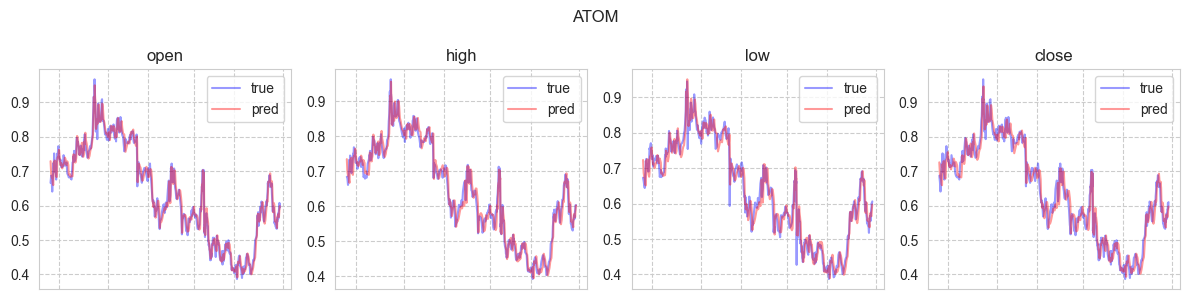

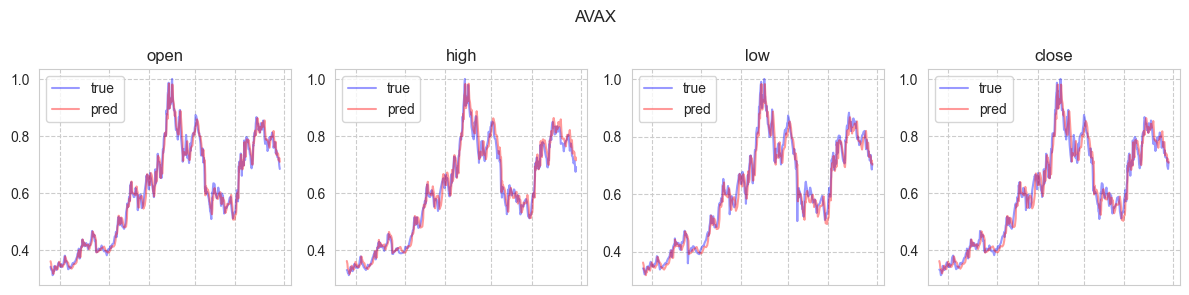

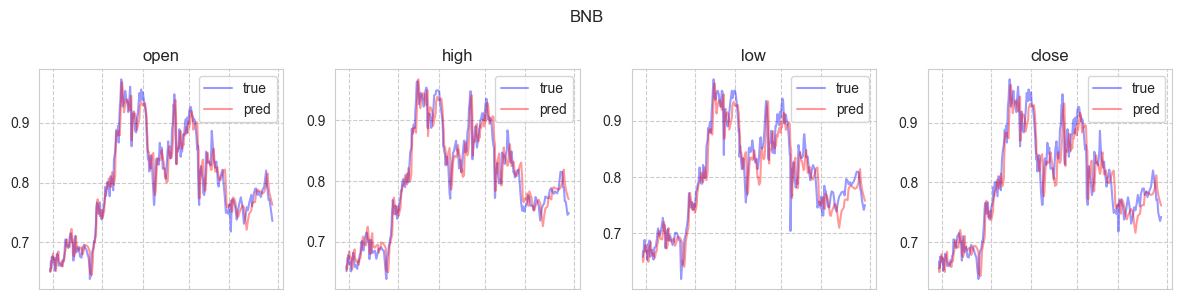

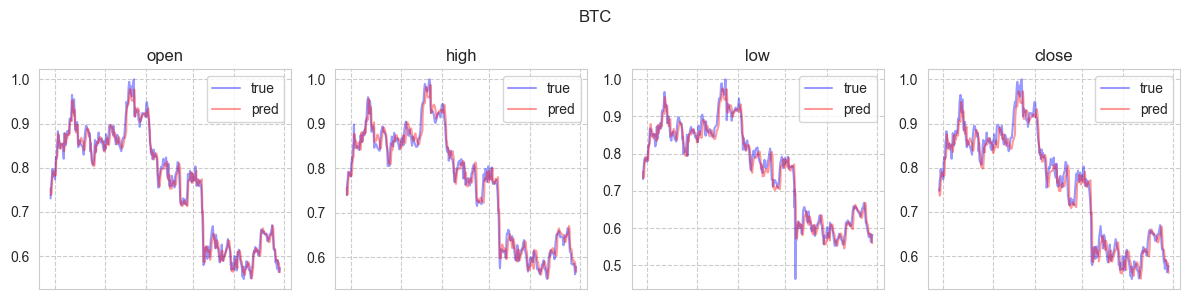

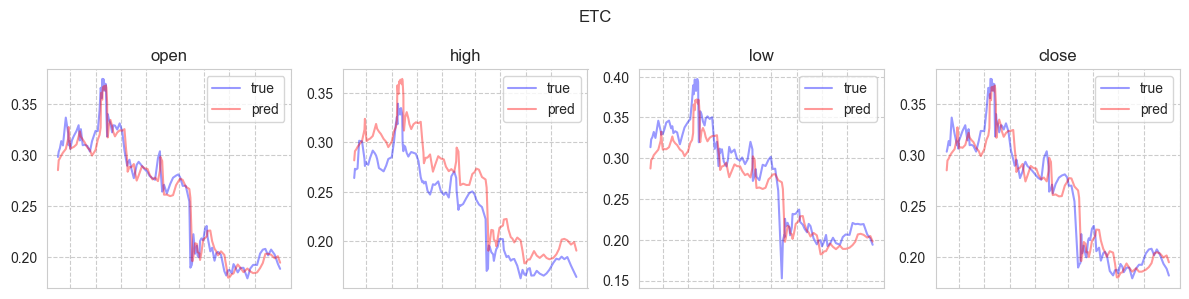

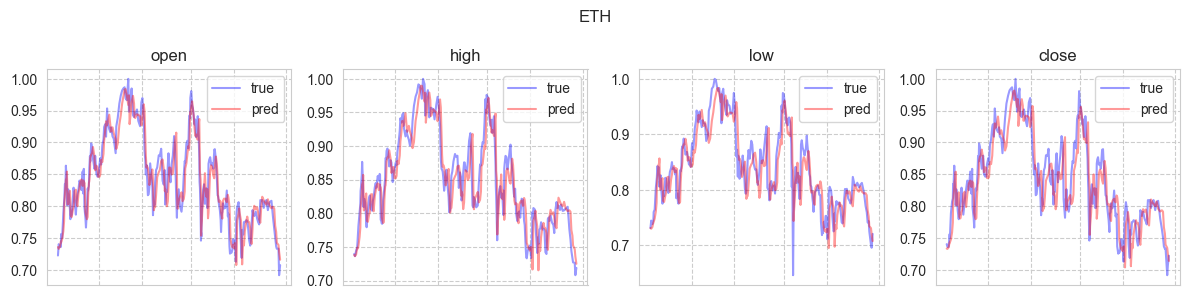

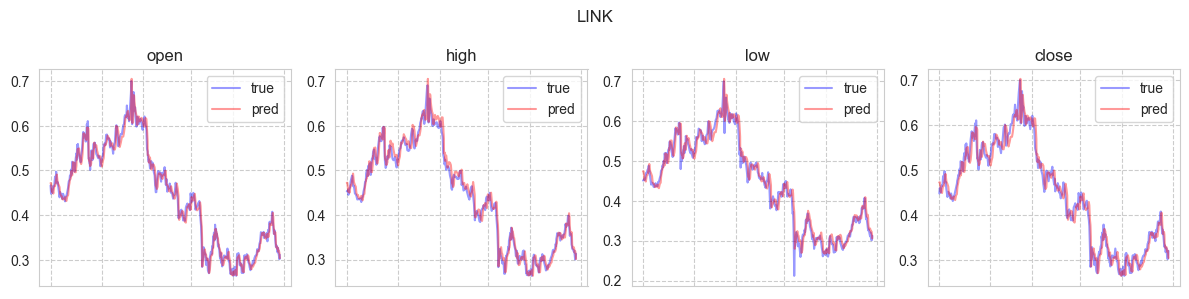

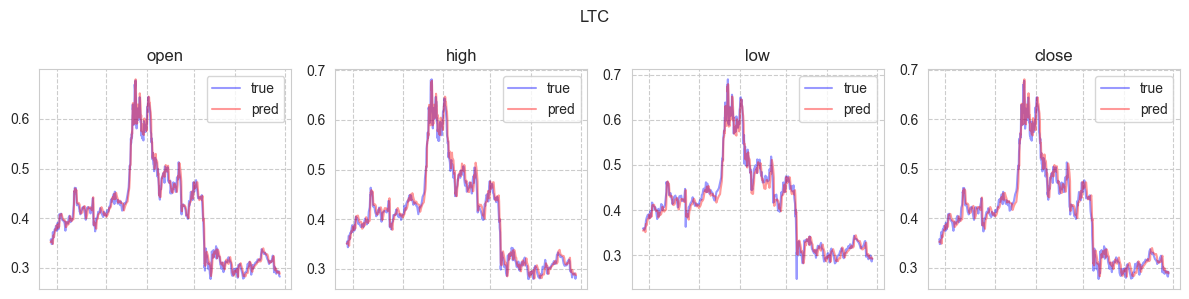

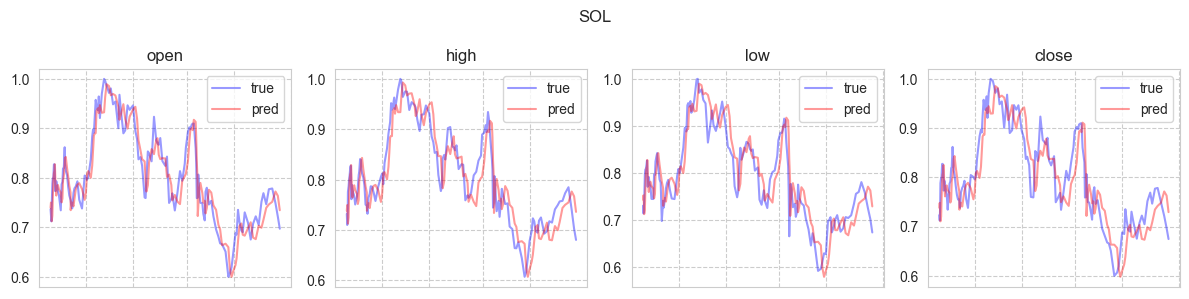

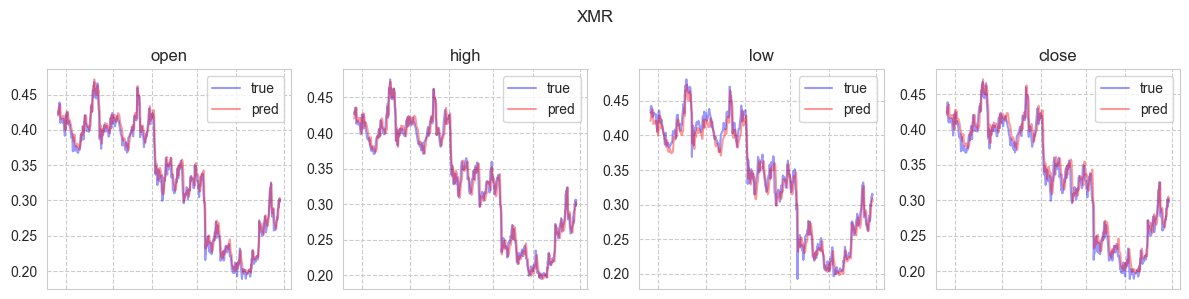

In [4]:
for ticker in df['ticker'].unique():
    fig, ax = plt.subplots(1, len(targets), figsize = (12, 3), sharex = True, sharey = False)
    for idx, _ax in enumerate(ax.flatten()):
        sns.lineplot(data = df[df['ticker'] == ticker], x = 'start', y = f'{targets[idx]}_true', ax = _ax, 
                     color = 'blue', label = 'true', alpha = 0.4)
        sns.lineplot(data = df[df['ticker'] == ticker], x = 'start', y = f'{targets[idx]}_pred', ax = _ax, 
                     color = 'red', label = 'pred', alpha = 0.4)

        xticks = _ax.get_xticks()
        xticklabels = [x.get_text() for x in _ax.get_xticklabels()]
        
        _ = _ax.set_xticks(xticks, xticklabels, rotation=90, visible=False)
        
        _ax.set_xlabel(None); _ax.set_ylabel(None)
        _ax.set_title(targets[idx])
        #_ax.set_axis_off()
        #_ax.set_ylim([0, 1])

    plt.suptitle(ticker)
    plt.tight_layout()
    plt.show()

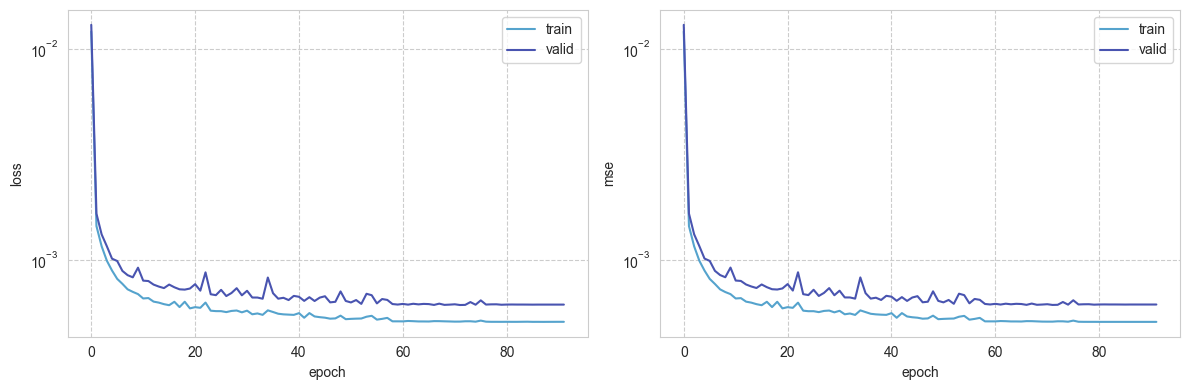

In [5]:
df_perf = pd.DataFrame(perf, columns = ['epoch', 'train_loss', 'valid_loss', 'train_mse', 'valid_mse', 'lr'])
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
columns = ['loss', 'mse']
for idx, _ax in enumerate(ax.flatten()):
    sns.lineplot(data = df_perf, x = 'epoch', y = f'train_{columns[idx]}', label = 'train', ax = _ax)
    sns.lineplot(data = df_perf, x = 'epoch', y = f'valid_{columns[idx]}', label = 'valid', ax = _ax)
    _ax.set_ylabel(columns[idx])
    _ax.set_yscale('log')
plt.tight_layout()
plt.show()

### MSE trend with forward lookup

In [6]:
targets = ['open', 'high', 'low', 'close']
#cols = ['start', 'ticker'] + [f'{c}_true' for c in targets] + [f'{c}_pred' for c in targets]
cols = ['epoch', 'train_loss', 'valid_loss', 'train_mse', 'valid_mse', 'lr']
dfs = []
for fold in [1, 2, 3]:
    for t in range(1, 10):
        for max_len in ['', '_128', '_192']:
            try:
                with open(f'../models/hslstm_baseline_t{t}{max_len}/results{fold}.pkl', 'rb') as f:
                    data = pickle.load(f)
                    df = pd.DataFrame(data, columns = cols)
                    df['fold'] = fold
                    df['lookahead'] = t
                    df['max_len'] = 64 if max_len == '' else int(max_len.replace('_', ''))
                    df['is_best'] = 0
                    df.loc[df['valid_loss'] == min(df['valid_loss']), 'is_best'] = 1
                    dfs.append(df)
            except:
                pass
        
df = pd.concat(dfs)
df['train_loss'] **= 0.5
df['valid_loss'] **= 0.5
df['train_loss'] *= 100
df['valid_loss'] *= 100
df.shape
        

(3524, 10)

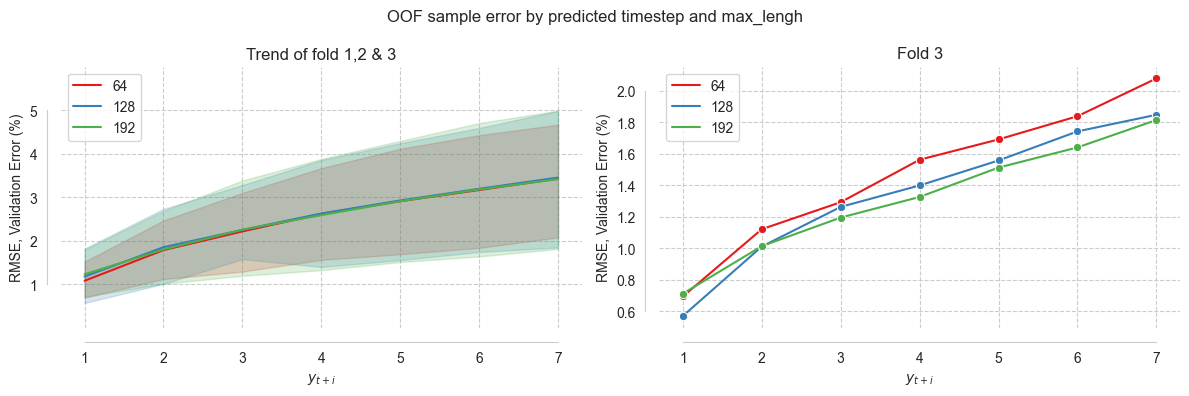

In [7]:
#agg = df.groupby(by = ['fold', 'lookahead', 'max_len'])[['train_loss', 'valid_loss']].min().reset_index()
agg = df[df['is_best'] == 1]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data = agg, x = 'lookahead', y = 'valid_loss', hue = 'max_len', palette='Set1', ax = ax[0])
sns.lineplot(data = agg[agg['fold'] == 3], x = 'lookahead', y = 'valid_loss', hue = 'max_len', marker = 'o', palette='Set1', ax = ax[1])
sns.despine(offset=10, trim=True, ax = ax[0])
sns.despine(offset=10, trim=True, ax = ax[1])
ax[0].set_ylim([0, 6])
ax[0].set_xlabel('$y_{t+i}$'); ax[0].set_ylabel('RMSE, Validation Error (%)')
ax[1].set_xlabel('$y_{t+i}$'); ax[1].set_ylabel('RMSE, Validation Error (%)')
ax[0].set_title('Trend of fold 1,2 & 3')
ax[1].set_title('Fold 3')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
plt.suptitle('OOF sample error by predicted timestep and max_lengh')
plt.tight_layout()
plt.show()

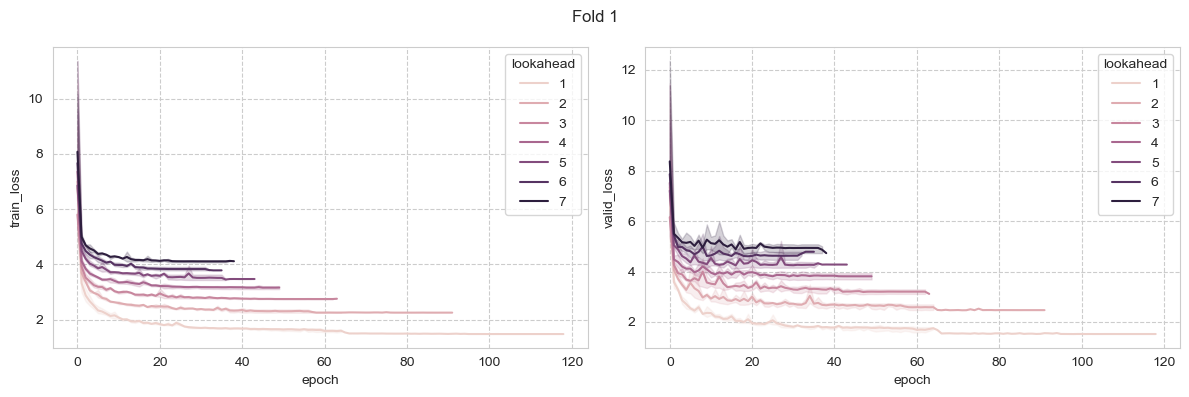

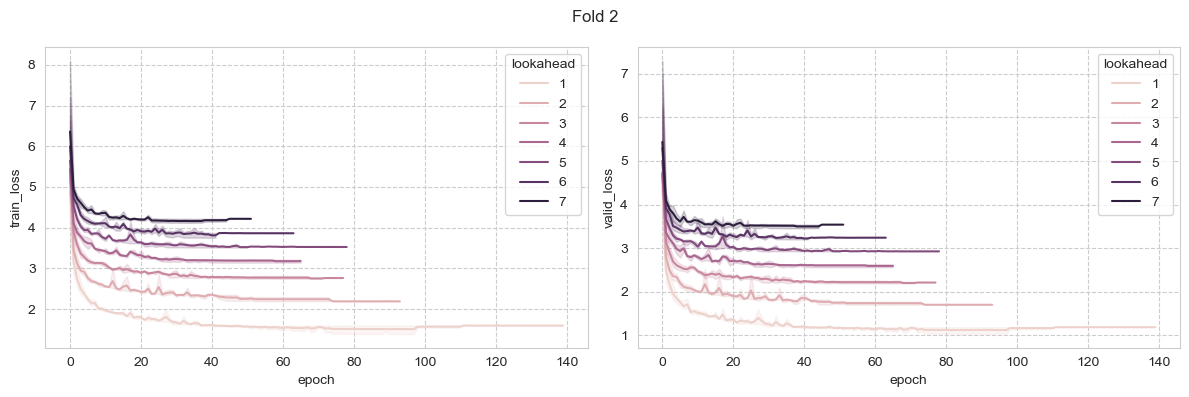

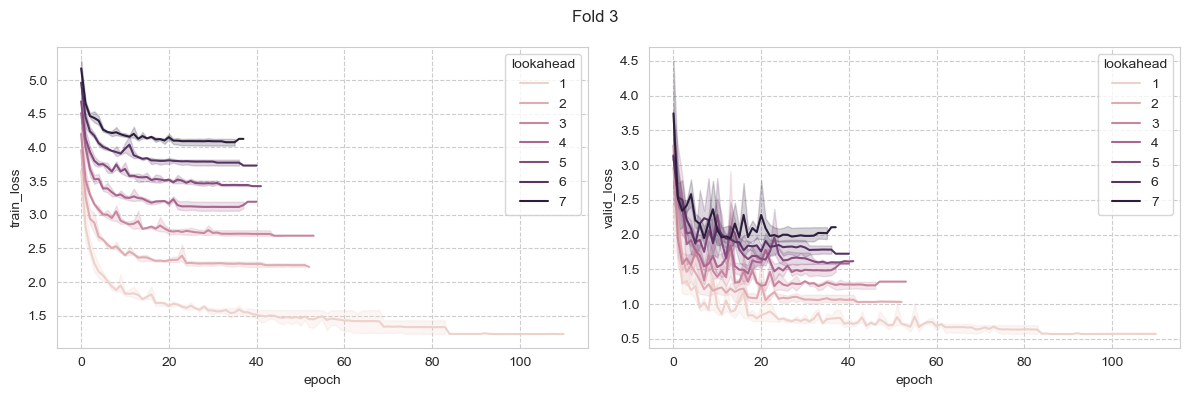

In [48]:
for fold in [1, 2, 3]:
    fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex = True, sharey = False)
    sns.lineplot(data = df[df['fold'] == fold], x = 'epoch', y = 'train_loss', hue = 'lookahead', ax = ax[0])
    sns.lineplot(data = df[df['fold'] == fold], x = 'epoch', y = 'valid_loss', hue = 'lookahead', ax = ax[1])
    #ax[0].set_xlim([0, 120]); ax[0].set_ylim([0, 0.05])
    #ax[1].set_xlim([0, 120]); ax[1].set_ylim([0, 0.05])
    plt.suptitle(f'Fold {fold}')
    plt.tight_layout()
    plt.show()

In [ ]:
folds = {
        1 : {
            'train': ('01-01-2021', '09-30-2021'),
            'valid': ('10-01-2021', '12-31-2021')
            },
        2 : {
            'train': ('01-01-2021', '12-31-2021'),
            'valid': ('01-01-2022', '03-31-2022')
        },
        3 : {
            'train': ('01-01-2021', '03-31-2022'),
            'valid': ('04-01-2022', '06-30-2022')
        },
    }

In [ ]:
df = pd.read_csv('../data/norm_train_volume_bars.csv')
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df.shape

In [ ]:
plt.figure(figsize = (12, 4))
colors = ['Black', 'Red', 'Green', 'Blue', 'Cyan']
labels = ['Train', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4']
alphas = [1.0, 0.8, 0.6, 0.4] + [0.3] * 10
linestyles = ['-', ':', '--'] * 4
tickers = ['ATOM', 'AVAX', 'BNB', 'BTC', 'ETC', 'ETH', 'LINK', 'LTC', 'SOL', 'XMR']
for fold in [0, 1, 2, 3]:
    (start, end) = folds[max(1, fold)]['train' if fold == 0 else 'valid']
    _df = df[(df['start'] >= start) & (df['end'] < end)]
    for idx, tick in enumerate(tickers):
        sns.lineplot(data = _df[_df['ticker'] == tick], x = 'start', y = 'close', color = colors[fold], 
                     label = labels[fold] if tick == 'BTC' else None,
                     alpha = alphas[idx], linestyle = linestyles[idx])
plt.show()